In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Get data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [3]:
# Analyze data

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
# Define a linear AutoEncoder 
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N (batch size), 784 (28x28)
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12), 
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # N, 784
            nn.Sigmoid() # IMPORTTANT! Depending on data we might need different activation here!
        )
# NOTE: Last activation: [0, 1] -> nn.ReLU(), [-1, 1] -> nn.Tanh

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    


In [5]:
# Instantiate neural net and optimizer
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [6]:
# Train the Autoencoder
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for img, _ in data_loader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))


Epoch:1, Loss:0.0482
Epoch:2, Loss:0.0432
Epoch:3, Loss:0.0469
Epoch:4, Loss:0.0443
Epoch:5, Loss:0.0435
Epoch:6, Loss:0.0395
Epoch:7, Loss:0.0346
Epoch:8, Loss:0.0356
Epoch:9, Loss:0.0388
Epoch:10, Loss:0.0399


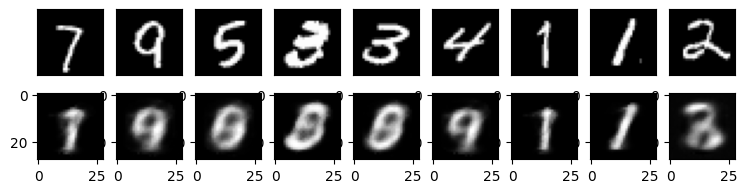

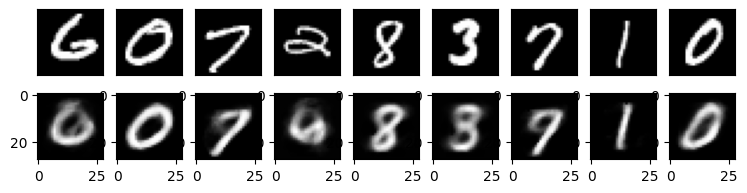

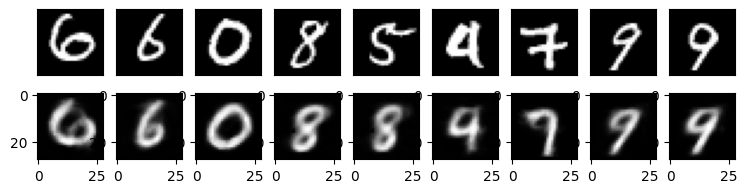

In [16]:
# Plot the reconstructed images
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break

        plt.subplot(2, 9, i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])